In [1]:
import cv2 as cv
import numpy as np
from tqdm.notebook import tqdm_notebook
import time
import os
import matplotlib.pyplot as plt
import bbox_visualizer as bbv
import torch
from yolov7_package import Yolov7Detector
import sys
import argparse

In [2]:
labels = open('YOLOv7/classes.names').read().strip().split('\n')
np.random.seed(42)

In [3]:
model = Yolov7Detector(weights='yolov7/runs/train/yolov7-cvor9/weights/best.pt', img_size=[416, 416], classes='YOLOv7/classes.names')

Fusing layers... 
IDetect.fuse


/anaconda/envs/py38_default/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484810403/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
def count_frames(path, override=False):
    # grab a pointer to the video file and initialize the total
    # number of frames read
    video = cv.VideoCapture(path)
    total = 0
    # if the override flag is passed in, revert to the manual
    # method of counting frames
    if override:
        total = count_frames_manual(video)
    # otherwise, let's try the fast way first
    else:
        # lets try to determine the number of frames in a video
        # via video properties; this method can be very buggy
        # and might throw an error based on your OpenCV version
        # or may fail entirely based on your which video codecs
        # you have installed
        try:
        # check if we are using OpenCV 3
        # if is_cv3():
        #     total = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        # # otherwise, we are using OpenCV 2.4
        # else:
            total = int(video.get(cv2.cv.CV_CAP_PROP_FRAME_COUNT))
        # uh-oh, we got an error -- revert to counting manually
        except:
            total = count_frames_manual(video)
    # release the video file pointer
    video.release()
    # return the total number of frames in the video
    return total

def count_frames_manual(video):
    # initialize the total number of frames read
    total = 0
    # loop over the frames of the video
    while True:
        # grab the current frame
        (grabbed, frame) = video.read()

        # check to see if we have reached the end of the
        # video
        if not grabbed:
            break
        # increment the total number of frames read
        total += 1
    # return the total number of frames in the video file
    return total

In [5]:
def lpf_for_object_detection(boxes, classes, total_frames, frame_ix, frame_itr, num_of_history_frames=11):
    # if there's enough frames to evaluate back and forth in time
    if (frame_ix >= num_of_history_frames-1 and frame_ix < total_frames): 
        frame_to_check = int((num_of_history_frames-1)/2) # (num_of_history_frames-1)/2 of past frames, and same for future frames
        classes, boxes, changed_frame_flag = cmp2history(boxes, classes, frame_to_check, frame_ix, num_of_history_frames)
    else:
        frame_to_check = frame_itr
        changed_frame_flag = False
    return classes, boxes, frame_to_check, changed_frame_flag
        
def cmp2history(boxes, classes, cur_frame_ix, frame_ix, num_of_history_frames=11):
    changed_frame_flag = False # DEBUG
    # check if past and future frames are equal
    for i in range(cur_frame_ix):
        if(classes[cur_frame_ix] == classes[i] or classes[cur_frame_ix] == list(reversed(classes[i]))): 
            cur_eq_past = True
        else: 
            cur_eq_past = False
            # print(f'{frame_ix}: classes[{cur_frame_ix}]={classes[cur_frame_ix]} != classes[{i}]={classes[i]}') # DEBUG
        if(classes[cur_frame_ix] == classes[num_of_history_frames-1-i] or classes[cur_frame_ix] == list(reversed(classes[num_of_history_frames-1-i]))):
            cur_eq_future = True
        else: 
            cur_eq_future = False
            # print(f'{frame_ix}: classes[{cur_frame_ix}]={classes[cur_frame_ix]} != classes[{num_of_history_frames-1-i}]={classes[num_of_history_frames-1-i]}') # DEBUG
    
    if(not(cur_eq_past) and not(cur_eq_future)):
        # print(f'{frame_ix}: old classes = {classes[cur_frame_ix]}') # DEBUG
        # print(f'{frame_ix}: old boxes   = {boxes[cur_frame_ix]}') # DEBUG
        boxes.pop(cur_frame_ix)
        classes.pop(cur_frame_ix)
        # find a good example from the past
        for i in range(cur_frame_ix):
            if (len(classes[num_of_history_frames-1-i])==2):
                new_frame_ix = num_of_history_frames-1-i
                future_frame_flag = True
                break
            else:
                future_frame_flag = False
        # if no example from the past, find one from the future
        if(not(future_frame_flag)):
            for i in range(cur_frame_ix):
                if (len(classes[i])==2):
                    new_frame_ix = i
                    break
                else: # if no good pred is around, use the current (no change)
                    new_frame_ix = cur_frame_ix
            
        # print(f'{frame_ix}: new classes = {classes[new_frame_ix]}') # DEBUG
        # print(f'{frame_ix}: new boxes   = {boxes[new_frame_ix]}') # DEBUG
        # insert previous close to correct predicition
        boxes.insert(cur_frame_ix, boxes[new_frame_ix])
        classes.insert(cur_frame_ix, classes[new_frame_ix])
        changed_frame_flag = True # DEBUG
    return classes, boxes, changed_frame_flag 

In [6]:
path_to_video = 'models/P019_tissue1.wm1'
video_name_with_path = path_to_video.split('.')[0]
total_frames = count_frames(path_to_video)

In [7]:
# cap = cv.VideoCapture('models/P019_tissue1.wm1')
cap = cv.VideoCapture(path_to_video)
frame_width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
video_fps = int(cap.get(cv.CAP_PROP_FPS))

size = (frame_width, frame_height)
result = cv.VideoWriter(f'{video_name_with_path}_result_with_lpf.mp4', 
                         cv.VideoWriter_fourcc(*'mp4v'),
                         video_fps, size)

all_classes, all_boxes = [], []
hist_boxes, hist_classes, hist_frames = [], [], []
frame_ix = 0
num_of_history_frames = 6+1 # (num_of_history_frames-1)/2 of past frames, and same for future frames
for frame_ix in tqdm_notebook(range(total_frames)):
    # while (cap.isOpened()):
    if (cap.isOpened()):
        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            # add bounding boxes
            # bbox = [xmin, ymin, xmax, ymax]
            classes, boxes, scores = model.detect(frame)

            boxes[0] = [[int(x) for x in box] for box in boxes[0]]
            # classes[0] = [[labels[class_id] for class_id in label] for label in classes]
            
            # keep the list with size of 'num_of_history_frames' 
            if(len(hist_classes) > num_of_history_frames or 
               len(hist_boxes)   > num_of_history_frames or
               len(hist_frames)  > num_of_history_frames):
                hist_classes.pop(0)
                hist_boxes.pop(0)
                hist_frames.pop(0)
            
            hist_classes.append(classes[0])
            hist_boxes.append(boxes[0])
            hist_frames.append(frame)
            
            frame_itr = frame_ix%num_of_history_frames
            hist_classes, hist_boxes, cur_frame_ix, changed_frame_flag = lpf_for_object_detection(hist_boxes, hist_classes, total_frames, frame_ix, frame_itr, num_of_history_frames)
            
            # final_classes  = [labels[hist_classes[frame_itr][1]], labels[hist_classes[frame_itr][0]]]
            final_classes  = [labels[class_id] for class_id in hist_classes[cur_frame_ix]]
            final_classes = [final_classes]
            
            all_classes.append(final_classes)
            all_boxes.append(hist_boxes[cur_frame_ix])
            
            cur_frame   = hist_frames[cur_frame_ix]
            cur_bbox    = hist_boxes[cur_frame_ix]
            cur_classes = final_classes[0]
            
            # frame = bbv.draw_multiple_rectangles(frame, boxes[0], bbox_color=(255,0,0))
            # frame = bbv.add_multiple_labels(frame, classes[0][0], boxes[0], text_bg_color=(255,0,0))
            frame = bbv.add_multiple_labels(cur_frame, cur_classes, cur_bbox, text_bg_color=(255,255,0))
            frame = bbv.draw_multiple_rectangles(cur_frame, cur_bbox, bbox_color=(255,255,0))
            

            # frame_ix+=1 
            ###########
            ## DEBUG ##
            ###########
            # if changed_frame_flag:
            #     # Dispilay the resulting frame
            #     print(cur_classes)
            #     print(cur_bbox)
            #     cv.imwrite('models/res_gabriel.jpg', frame)
            #     input("press somthing...")
            ###########
            result.write(frame)

            # Press Q on keyboard to  exit
            if cv.waitKey(33) & 0xFF == ord('q'):
                break

        # Break the loop
        else:
            break
    # Break the main loop
    else: 
        break

# When everything done, release the video capture object
cap.release()
result.release()
print('DONE!')

  0%|          | 0/4586 [00:00<?, ?it/s]

DONE!


In [26]:
for i in range(len(all_boxes)):
    print(f'{i}: {all_boxes[i]}')

0: [[110, 229, 184, 320], [411, 249, 486, 360]]
1: [[110, 229, 184, 320], [411, 248, 486, 360]]
2: [[110, 229, 184, 320], [411, 248, 486, 360]]
3: [[110, 229, 184, 320], [411, 248, 486, 360]]
4: [[110, 229, 184, 320], [411, 248, 486, 360]]
5: [[110, 229, 184, 320], [411, 248, 486, 360]]
6: [[110, 229, 184, 320], [411, 248, 486, 360]]
7: [[110, 229, 184, 320], [411, 248, 486, 360]]
8: [[110, 229, 184, 320], [411, 248, 486, 360]]
9: [[110, 229, 184, 320], [411, 248, 486, 359]]
10: [[110, 229, 184, 320], [411, 248, 486, 360]]
11: [[110, 229, 184, 320], [411, 248, 486, 360]]
12: [[110, 229, 184, 320], [411, 249, 486, 360]]
13: [[110, 229, 184, 320], [411, 249, 486, 360]]
14: [[110, 229, 184, 320], [411, 248, 486, 360]]
15: [[110, 229, 184, 320], [411, 248, 486, 360]]
16: [[110, 229, 184, 320], [411, 248, 486, 360]]
17: [[110, 229, 184, 320], [411, 248, 486, 360]]
18: [[110, 229, 184, 320], [411, 248, 486, 360]]
19: [[110, 229, 184, 320], [411, 248, 486, 360]]
20: [[110, 229, 184, 320], [41

In [54]:
for i in range(len(all_classes)):
    print(f'{i}: {all_classes[i]}')

0: [['Right_Empty', 'Left_Empty']]
1: [['Right_Empty', 'Left_Empty']]
2: [['Right_Empty', 'Left_Empty']]
3: [['Right_Empty', 'Left_Empty']]
4: [['Right_Empty', 'Left_Empty']]
5: [['Right_Empty', 'Left_Empty']]
6: [['Right_Empty', 'Left_Empty']]
7: [['Right_Empty', 'Left_Empty']]
8: [['Right_Empty', 'Left_Empty']]
9: [['Right_Empty', 'Left_Empty']]
10: [['Right_Empty', 'Left_Empty']]
11: [['Right_Empty', 'Left_Empty']]
12: [['Right_Empty', 'Left_Empty']]
13: [['Right_Empty', 'Left_Empty']]
14: [['Right_Empty', 'Left_Empty']]
15: [['Right_Empty', 'Left_Empty']]
16: [['Right_Empty', 'Left_Empty']]
17: [['Right_Empty', 'Left_Empty']]
18: [['Right_Empty', 'Left_Empty']]
19: [['Right_Empty', 'Left_Empty']]
20: [['Right_Empty', 'Left_Empty']]
21: [['Right_Empty', 'Left_Empty']]
22: [['Right_Empty', 'Left_Empty']]
23: [['Right_Empty', 'Left_Empty']]
24: [['Right_Empty', 'Left_Empty']]
25: [['Right_Empty', 'Left_Empty']]
26: [['Right_Empty', 'Left_Empty']]
27: [['Right_Empty', 'Left_Empty']]
28

In [ ]:
for i in range(len(all_boxes)):
    print(f'{i}: {all_classes[i]}')
    print(f'{i}: {all_boxes[i]}')

0: [['Right_Empty', 'Left_Empty']]
0: [[110, 229, 184, 320], [411, 249, 486, 360]]
1: [['Right_Empty', 'Left_Empty']]
1: [[110, 229, 184, 320], [411, 248, 486, 360]]
2: [['Right_Empty', 'Left_Empty']]
2: [[110, 229, 184, 320], [411, 248, 486, 360]]
3: [['Right_Empty', 'Left_Empty']]
3: [[110, 229, 184, 320], [411, 248, 486, 360]]
4: [['Right_Empty', 'Left_Empty']]
4: [[110, 229, 184, 320], [411, 248, 486, 360]]
5: [['Right_Empty', 'Left_Empty']]
5: [[110, 229, 184, 320], [411, 248, 486, 359]]
6: [['Right_Empty', 'Left_Empty']]
6: [[110, 229, 184, 320], [411, 248, 486, 360]]
7: [['Right_Empty', 'Left_Empty']]
7: [[110, 229, 184, 320], [411, 248, 486, 360]]
8: [['Right_Empty', 'Left_Empty']]
8: [[110, 229, 184, 320], [411, 249, 486, 360]]
9: [['Right_Empty', 'Left_Empty']]
9: [[110, 229, 184, 320], [411, 249, 486, 360]]
10: [['Right_Empty', 'Left_Empty']]
10: [[110, 229, 184, 320], [411, 248, 486, 359]]
11: [['Right_Empty', 'Left_Empty']]
11: [[110, 229, 184, 320], [411, 248, 486, 360]]


In [135]:
type([final_classes])

list

In [115]:
print(cur_frame_ix)
print(hist_boxes[cur_frame_ix])
print()
for i in range(len(hist_boxes)):
    print(hist_boxes[i])

5
[[75, 118, 160, 240], [82, 189, 228, 294]]

[[66, 121, 153, 259], [73, 193, 220, 300]]
[[67, 121, 154, 261], [76, 191, 222, 299]]
[[70, 121, 156, 252], [77, 191, 224, 297]]
[[71, 120, 157, 252], [79, 191, 226, 296]]
[[73, 119, 159, 246], [81, 190, 227, 296]]
[[75, 118, 160, 240], [82, 189, 228, 294]]
[[83, 189, 230, 294], [75, 118, 160, 231], [76, 117, 160, 237], [83, 189, 230, 294]]
[[82, 188, 231, 293], [76, 117, 160, 230], [77, 116, 160, 233], [84, 189, 231, 293]]
[[78, 115, 160, 232], [77, 116, 160, 231], [85, 188, 232, 292]]
[[79, 115, 159, 231], [85, 188, 233, 292]]
[[79, 115, 158, 229], [80, 114, 158, 229], [87, 188, 234, 291]]


In [27]:
print(cur_frame_ix)
for i in range(len(hist_boxes)):
    print(hist_boxes[i])#[cur_frame_ix]
    print(hist_classes[i])

5
[[393, 175, 492, 281], [233, 168, 388, 283]]
[7, 2]
[[390, 176, 491, 280], [232, 169, 390, 283]]
[7, 2]
[[385, 178, 492, 281], [233, 170, 394, 282]]
[7, 2]
[[233, 172, 396, 280], [382, 181, 491, 283]]
[2, 7]
[[233, 172, 392, 278], [380, 187, 490, 288]]
[2, 7]
[[231, 173, 386, 275], [377, 193, 488, 293]]
[2, 7]
[[230, 175, 383, 273], [374, 200, 486, 300]]
[2, 7]
[[230, 176, 382, 274], [369, 208, 484, 304]]
[2, 7]
[[227, 175, 384, 278], [365, 215, 482, 311]]
[2, 7]
[[225, 175, 391, 279], [364, 221, 480, 317]]
[2, 7]
[[363, 227, 478, 321], [229, 177, 388, 280]]
[7, 2]


In [11]:
final_classes  = [labels[hist_classes[0][1]], labels[hist_classes[0][0]]]
print(final_classes)

['Right_Needle_driver', 'Left_Empty']


In [6]:
# id_to_label = {0: 'Right_Scissors', 
#                1: 'Left_Scissors', 
#                2: 'Right_Needle_driver',
#                3: 'Left_Needle_driver',
#                4: 'Right_Forceps',
#                5: 'Left_Forceps',
#                6: 'Right_Empty',
#                7: 'Left_Empty'}

In [9]:
cap = cv.VideoCapture('models/P019_tissue1.wm1')
for i in range(5):
    ret, frame = cap.read()
    if ret == True:
        blob = cv.dnn.blobFromImage(frame, 1/255.0, (416, 416), swapRB=True, crop=False)
        # inference
        net.setInput(blob)
        outputs = net.forward(ln)
        boxes = []
        confidences = []
        classIDs = []
        h, w = frame.shape[:2]
        # Creation of bboxes
        for output in outputs:
            for detection in output:
                scores = detection[5:]
                classID = np.argmax(scores)
                confidence = scores[classID]
                if confidence > 0.5:
                    box = detection[:4] * np.array([w, h, w, h])
                    (centerX, centerY, width, height) = box.astype("int")
                    x = int(centerX - (width / 2))
                    y = int(centerY - (height / 2))
                    box = [x, y, int(width), int(height)]
                    boxes.append(box)
                    confidences.append(float(confidence))
                    classIDs.append(classes[classID])
        print(f'boxes - {boxes}')
        print(f'labels - {classIDs}')
        frame = bbv.draw_multiple_rectangles(frame, boxes, bbox_color=(255,0,0))
        frame = bbv.add_multiple_labels(frame, classIDs, boxes, text_bg_color=(255,0,0))
        cv.imwrite(f'models/results/{i}.jpg', frame)

cap.release()

boxes - [[412, 272, 88, 84], [411, 266, 84, 88], [604, 346, 33, 72]]
labels - ['Hand', 'Hand', 'Hand']
boxes - [[409, 270, 86, 82], [605, 345, 31, 74]]
labels - ['Hand', 'Hand']
boxes - [[410, 269, 84, 83]]
labels - ['Hand']
boxes - [[410, 270, 85, 81], [605, 346, 32, 72]]
labels - ['Hand', 'Hand']
boxes - [[604, 346, 32, 71]]
labels - ['Hand']


Text(3, 8, 'Blob shape=(1, 3, 416, 416)')

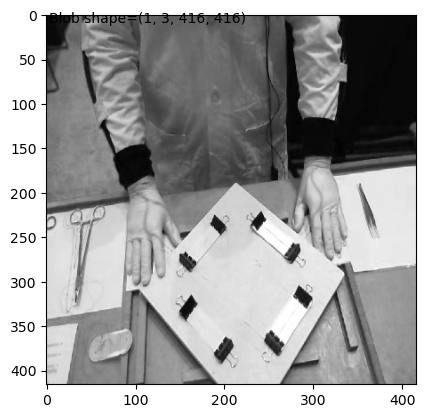

In [7]:
# construct a blob from the image
blob = cv.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)
r = blob[0, 0, :, :]

fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(cv.cvtColor(r, cv.COLOR_BGR2RGB))
text = f'Blob shape={blob.shape}'
ax.text(3, 8, text)

In [8]:
# net.setInput(blob)
# t0 = time.time()
# outputs = net.forward(ln)
# t = time.time()
# print('time=', t-t0)

# print(len(outputs))
# for out in outputs:
#     print(out.shape)

time= 0.4056825637817383
2
(507, 6)
(2028, 6)


In [9]:
def trackbar2(x):
    confidence = x/100
    r = r0.copy()
    for output in np.vstack(outputs):
        if output[4] > confidence:
            x, y, w, h = output[:4]
            p0 = int((x-w/2)*416), int((y-h/2)*416)
            p1 = int((x+w/2)*416), int((y+h/2)*416)
            cv.rectangle(r, p0, p1, 1, 1)
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.imshow(cv.cvtColor(r, cv.COLOR_BGR2RGB))
    text = f'Bbox confidence={confidence}'
    ax.text(output[0], output[1], text)

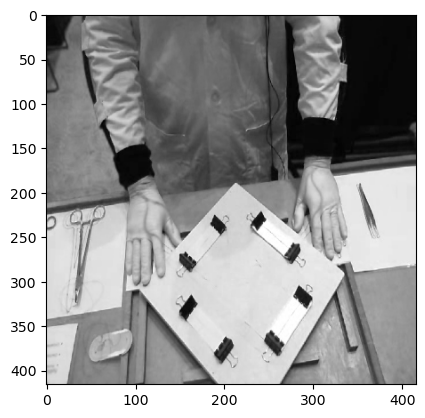

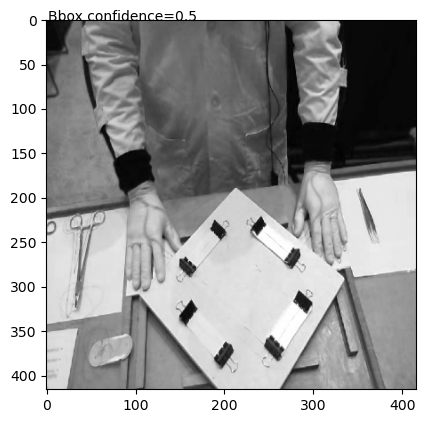

In [10]:
r0 = blob[0, 0, :, :]
r = r0.copy()
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(cv.cvtColor(r, cv.COLOR_BGR2RGB))
# cv.createTrackbar('confidence', 'blob', 50, 101, trackbar2)
trackbar2(50)

In [11]:
boxes = []
confidences = []
classIDs = []
h, w = img.shape[:2]

In [12]:
for output in outputs:
    for detection in output:
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        if confidence > 0.5:
            box = detection[:4] * np.array([w, h, w, h])
            (centerX, centerY, width, height) = box.astype("int")
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            box = [x, y, int(width), int(height)]
            boxes.append(box)
            confidences.append(float(confidence))
            classIDs.append(classID)

In [13]:
indices = cv.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
if len(indices) > 0:
    for i in indices.flatten():
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        color = [int(c) for c in colors[classIDs[i]]]
        cv.rectangle(img, (x, y), (x + w, y + h), color, 2)
        text = "{}: {:.4f}".format(classes[classIDs[i]], confidences[i])
        cv.putText(img, text, (x, y - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)


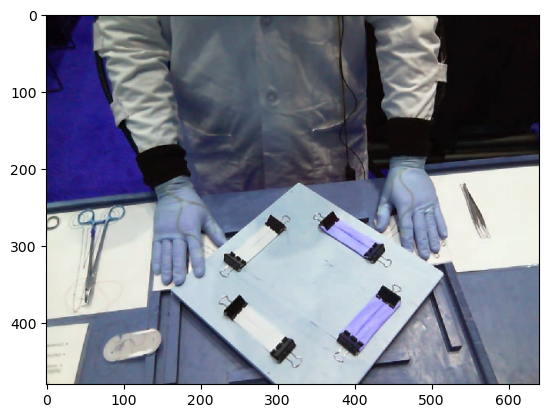

In [14]:
plt.imshow(img)